In [1]:
import matplotlib.pyplot as plt
import numpy as np
from cutde.halfspace import disp, strain, strain_to_stress
import cutde.halfspace as FS
from scipy.interpolate import griddata

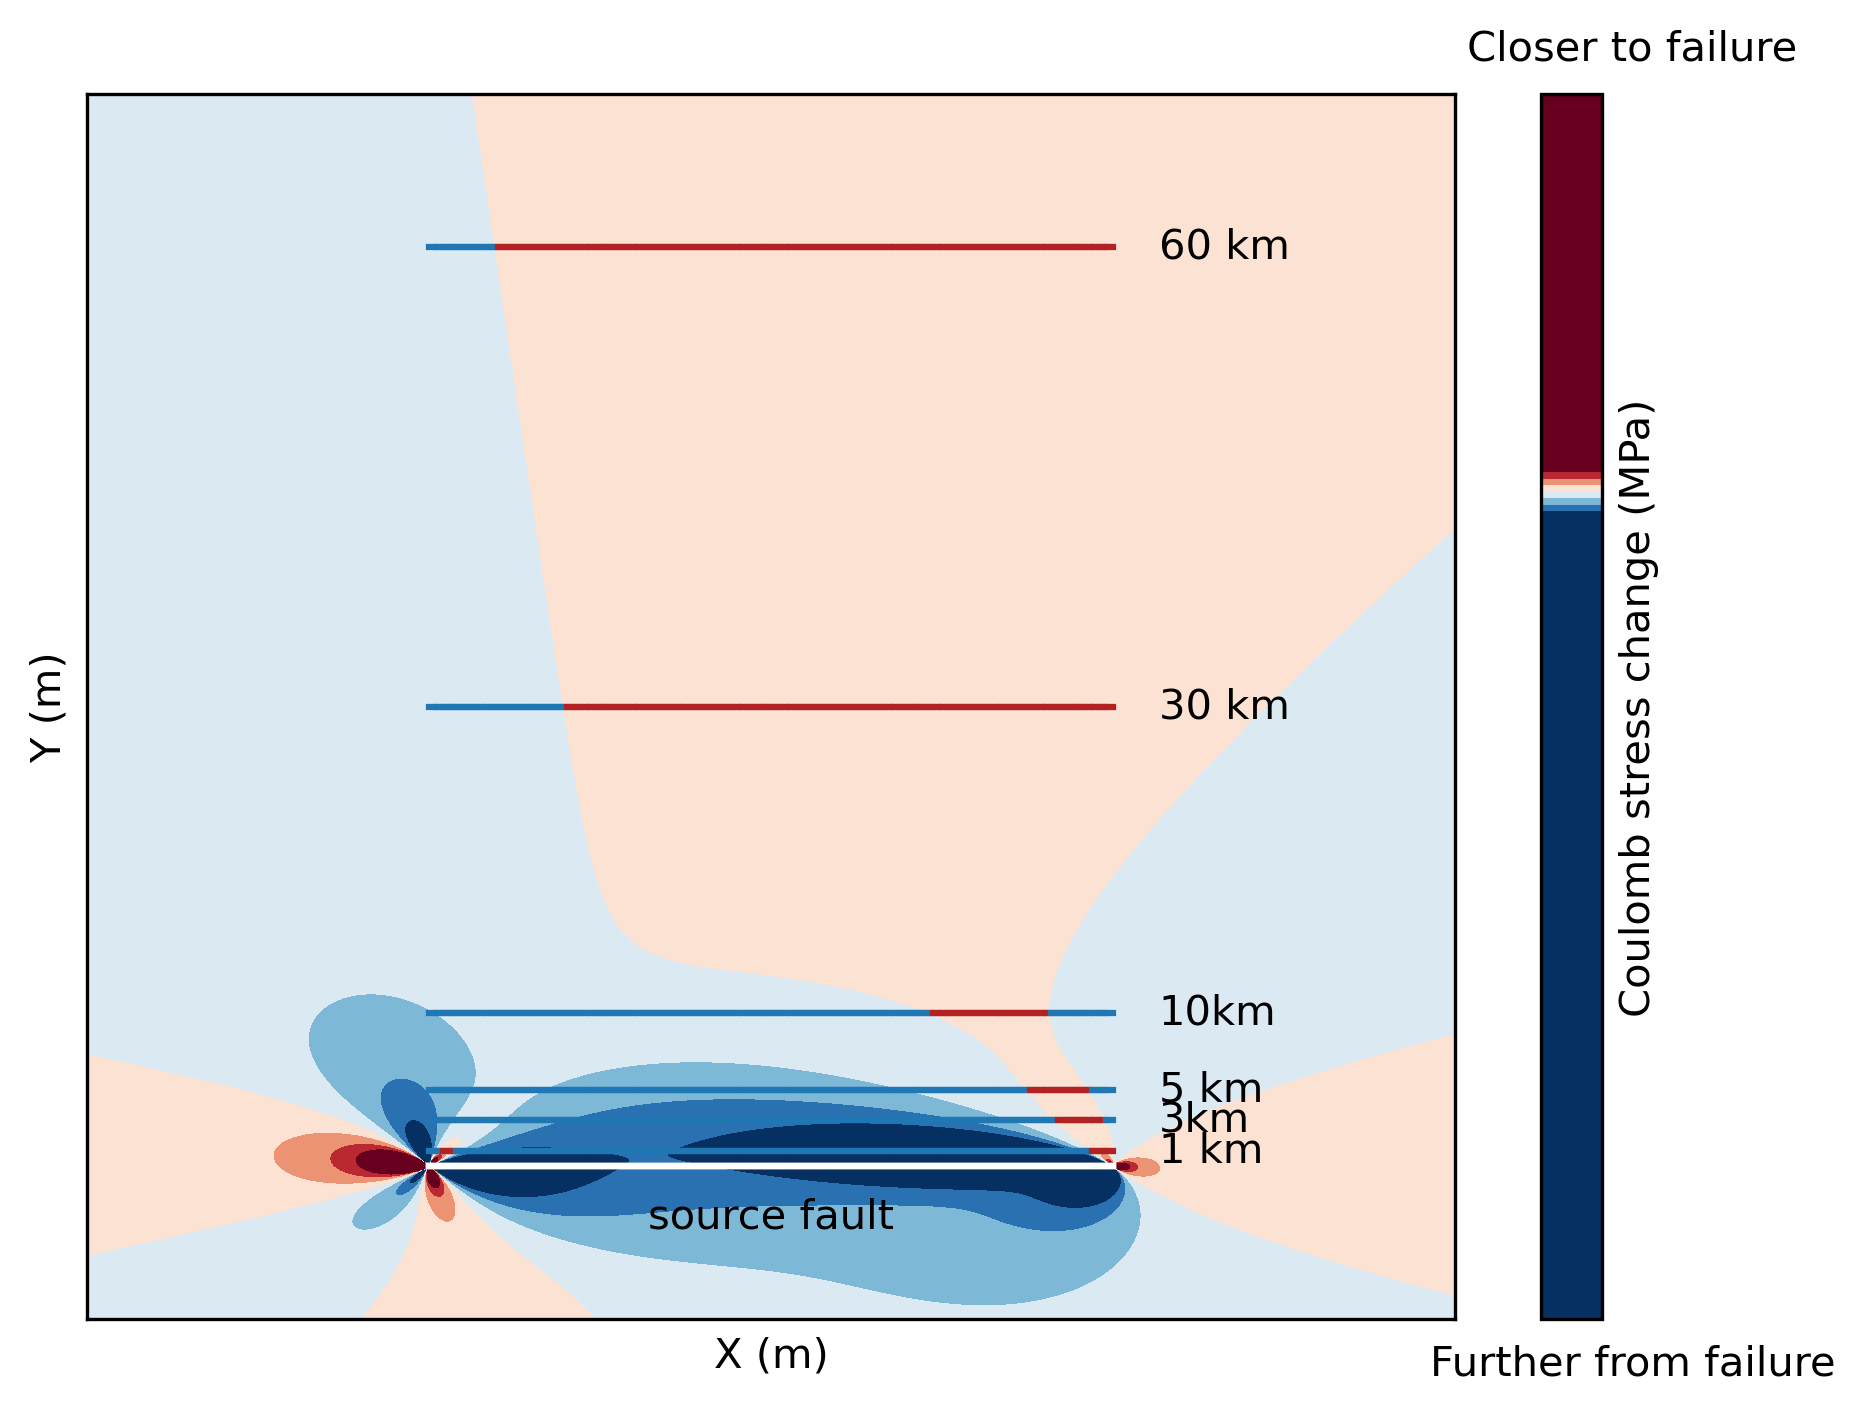

In [2]:
strike_length = 30000  # 30 km fault length
y_min = -10000         
y_max = 70000          
x_grid_length = 60000  
y_grid_length = y_max - y_min  
x_center = x_grid_length / 2
nu = 0.25
sm = 30 * 10**10 
mu = 0.6

#  observation pts
x = np.linspace(0, x_grid_length, 300)  
y = np.linspace(y_min, y_max, 300)     
X, Y = np.meshgrid(x, y)
Z = 0 * np.ones_like(X) # observation at z=0

#
src_tris = np.array([
    [[x_center - strike_length / 2, 0, 0],    # Top-left
    [x_center + strike_length / 2, 0, 0],    # Top-right 
    [x_center - strike_length / 2, 0, -12000]],  # Bottom-left 
    
    [[x_center + strike_length / 2, 0, 0],    # Top-right 
    [x_center + strike_length / 2, 0, -12000],  # Bottom-right 
    [x_center - strike_length / 2, 0, -12000]]  # Bottom-left 
])

slips = np.array([[-1.0, 0.0, 0.0], [-1.0, 0.0, 0.0]]) # RL slip

stress_xx = np.zeros_like(X)
stress_yy = np.zeros_like(X)
stress_xy = np.zeros_like(X)
coulomb_stress = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        obs_pt = np.array([[X[i, j], Y[i, j], Z[i, j]], [X[i, j], Y[i, j], Z[i, j]]]) 
        displacements = disp(obs_pt, src_tris, slips, nu)
        strains = strain(obs_pt, src_tris, slips, nu)
        stresses = strain_to_stress(strains, sm, nu)
        
        stress_xx[i, j] = stresses[0, 0]  
        stress_yy[i, j] = stresses[0, 1]  
        stress_xy[i, j] = stresses[0, 3]  
        
        sigma_n = stress_yy[i, j]
        tau = stress_xy[i, j]
        coulomb_stress[i, j] = tau - mu * sigma_n  # P=0

coulomb_stress_mpa = coulomb_stress / 1e6

plt.figure(dpi=300)
c = plt.contourf(X, Y, coulomb_stress_mpa, 200, cmap='RdBu_r', vmin=-20, vmax=20)
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

cb = plt.colorbar(c)
cb.set_label('Coulomb stress change (MPa)')
cb.ax.set_yticks([])
cb.ax.text(1.5, 1.02, 'Closer to failure', transform=cb.ax.transAxes, ha='center', va='bottom')
cb.ax.text(1.5, -0.02, 'Further from failure', transform=cb.ax.transAxes, ha='center', va='top')
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.text(x_center, -2000, 'source fault', horizontalalignment='center', verticalalignment='top', fontsize=10)

for tri in src_tris:
    plt.plot([tri[0, 0], tri[1, 0]], [tri[0, 1], tri[1, 1]], color='w')
    plt.plot([tri[1, 0], tri[2, 0]], [tri[1, 1], tri[2, 1]], color='w')
    plt.plot([tri[2, 0], tri[0, 0]], [tri[2, 1], tri[0, 1]], color='w')

distances = [1000, 3000, 5000,  10000, 30000, 60000]
labels = ['1 km', '3km','5 km','10km', '30 km', '60 km']
for idx, dist in enumerate(distances):
    x_line = np.array([x_center - strike_length / 2, x_center + strike_length / 2])
    y_line = np.array([dist, dist])
    
    x_vals = np.linspace(x_line[0], x_line[1], 100)
    y_vals = np.linspace(y_line[0], y_line[1], 100)
    points = np.c_[X.ravel(), Y.ravel()]
    stress_vals = griddata(points, coulomb_stress_mpa.ravel(), (x_vals, y_vals), method='linear')
    
    for j in range(len(stress_vals) - 1):
        color = 'firebrick' if stress_vals[j] > 0 else 'tab:blue'
        plt.plot(x_vals[j:j+2], y_vals[j:j+2], color=color)

    plt.text(x_center + strike_length / 2 + 2000, dist, labels[idx], verticalalignment='center')
plt.tight_layout()
plt.savefig('Figures/Coulomb_stress_change.pdf')


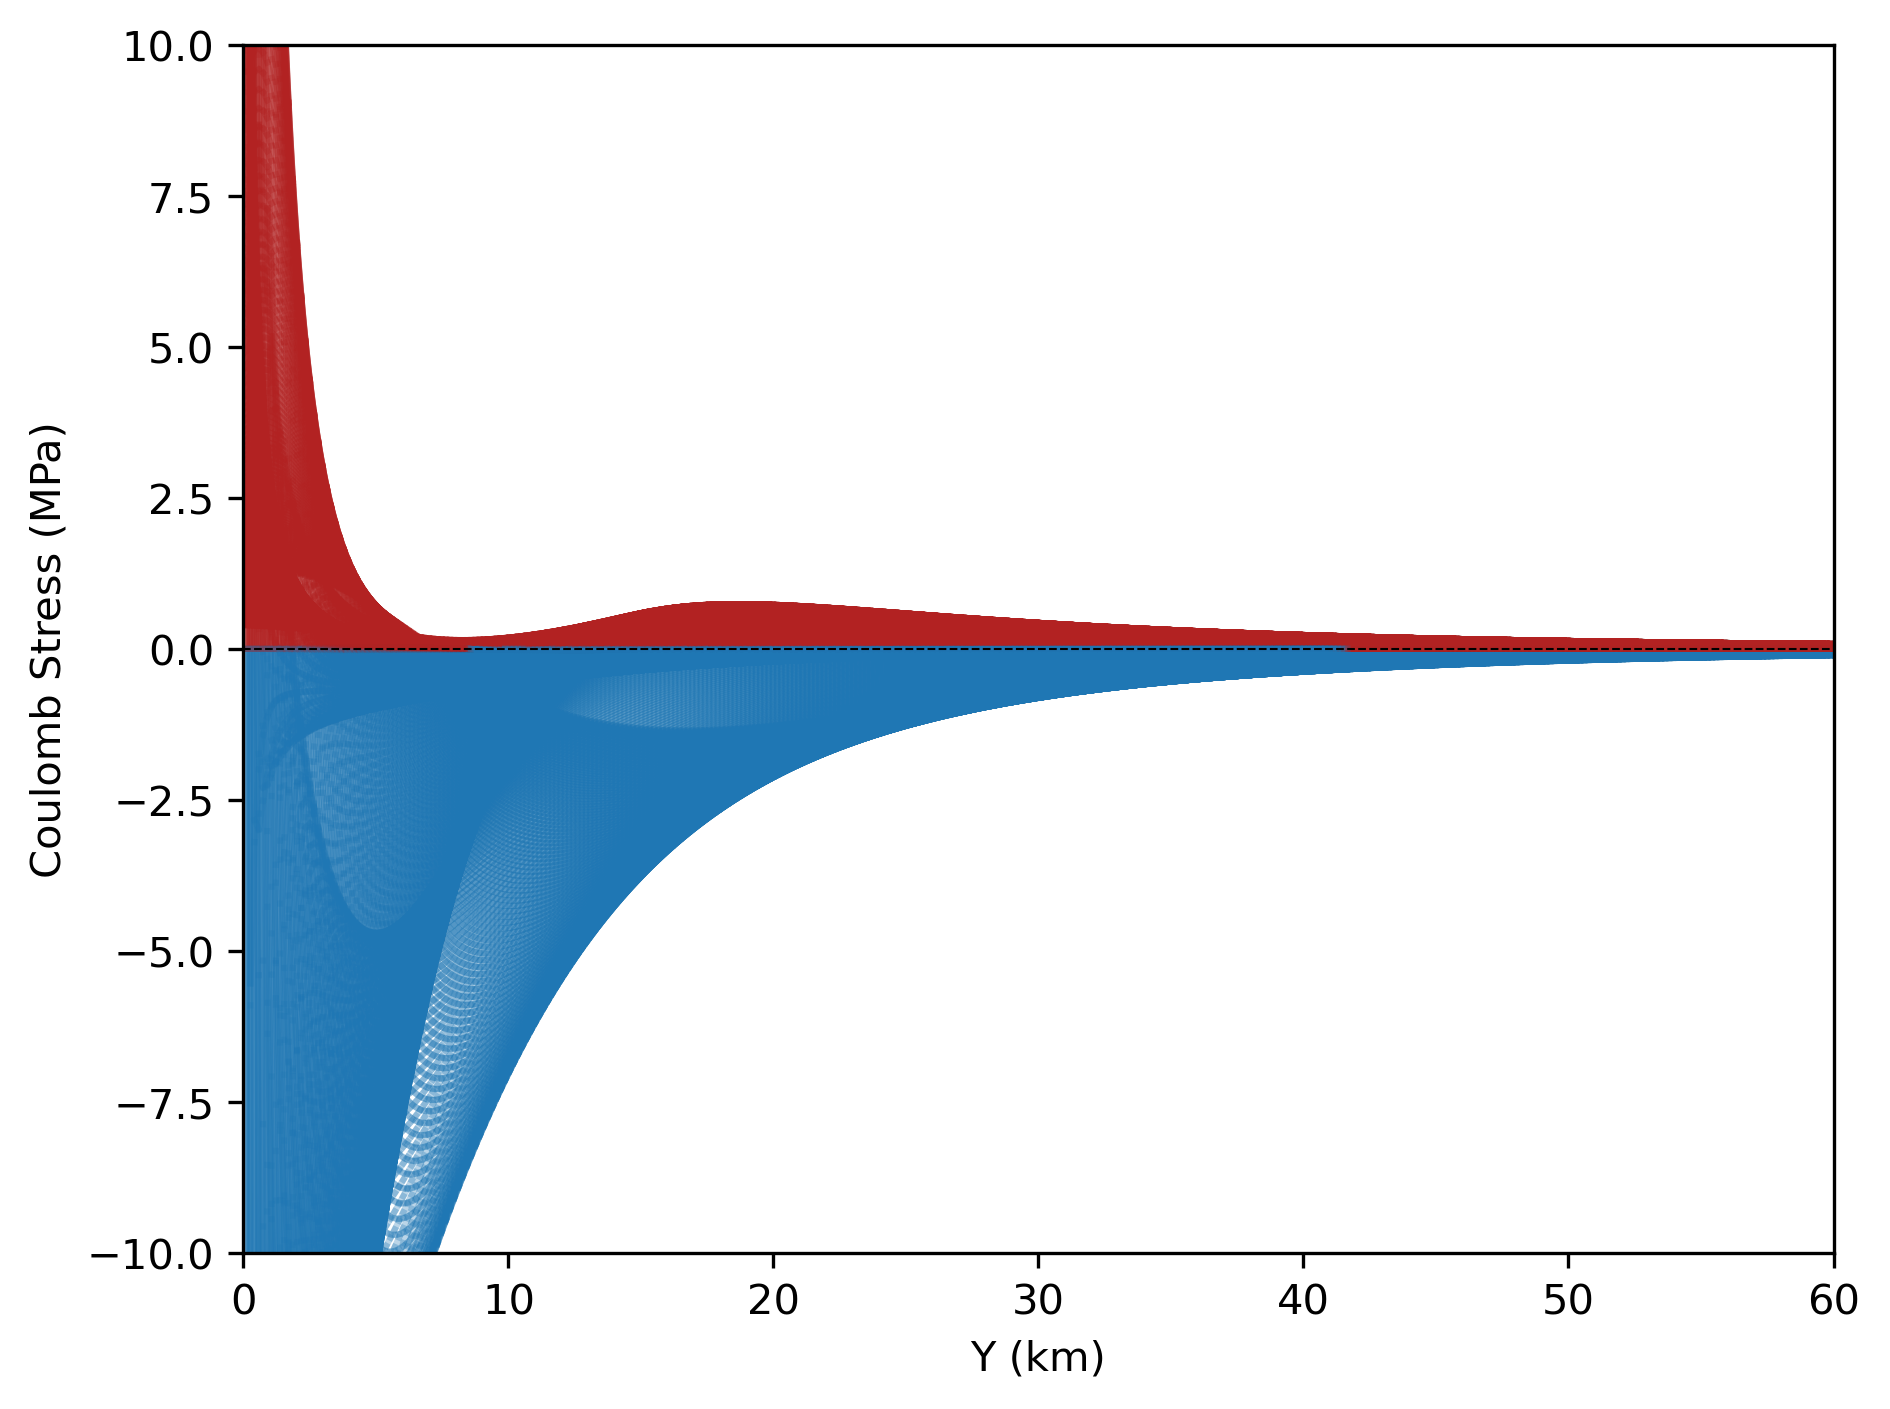

In [3]:
plt.figure(dpi=300)

threshold = 1e-10
for i in range(coulomb_stress_mpa.shape[1]):
    for j in range(coulomb_stress_mpa.shape[0] - 1):
        stress_values = coulomb_stress_mpa[j:j+2, i]
        y_values = Y[j:j+2, i] / 1000
        
        stress_values[np.abs(stress_values) < threshold] = 0

        if stress_values[0] > 0 and stress_values[1] > 0:
            plt.plot(y_values, stress_values, color='firebrick', alpha=0.3)
        
        elif stress_values[0] < 0 and stress_values[1] < 0:
            plt.plot(y_values, stress_values, color='tab:blue', alpha=0.3)
        
        else:
            zero_crossing = y_values[0] + (y_values[1] - y_values[0]) * (-stress_values[0]) / (stress_values[1] - stress_values[0])
            if stress_values[0] > 0:
                plt.plot([y_values[0], zero_crossing], [stress_values[0], 0], color='firebrick', alpha=0.3)
                plt.plot([zero_crossing, y_values[1]], [0, stress_values[1]], color='tab:blue', alpha=0.3)
            else:
                plt.plot([y_values[0], zero_crossing], [stress_values[0], 0], color='tab:blue', alpha=0.3)
                plt.plot([zero_crossing, y_values[1]], [0, stress_values[1]], color='firebrick', alpha=0.3)

plt.xlabel('Y (km)')
plt.ylabel('Coulomb Stress (MPa)')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.xlim(0, 60)
plt.ylim(-10, 10)
plt.tight_layout()
plt.savefig('Figures/Coulomb_stress_decay.pdf')